Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as any collaborators you worked with:

In [1]:
COLLABORATORS = ""

---

In [44]:
from __future__ import print_function
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# HW 6:  ODE Methods - Boundary Value Problems

This homework will combine a lot of previous codes to solve simple linear and non-linear Boundary value problems

This problem set has two questions

## Question 1 - A linear ODE BVP

Consider the *linear* non-homogeneous 2-pt boundary value problem

$$
    u^{\prime\prime}+ u = \sin3x\quad\quad x\in[0,L],\quad u(0)=u(L)=0
$$

which is related to the modes of vibration of a forced string of length $L$.

**(a)** [6] Find an analytic solution to this problem for general $L$ (hint:
  remember your basic ODE's for constant-coefficient problems).  Is
  this solution unique?

\begin{equation}
u(x)=c_{1} e^x+c_{2}e^{-x}-\frac{1}{10}sin(3x) \\
0=c_{1} +c_{2} => c_{1}=-c_{2} \\
0=c_{1} e^L+c_{2}e^{-L}-\frac{1}{10}sin(3L)
\end{equation}

**(b)** [4]  create a function `u_true(x,L)` and plot your solution for $L=10$ evaluated on a regularly spaced set of points $\mathbf{x}$

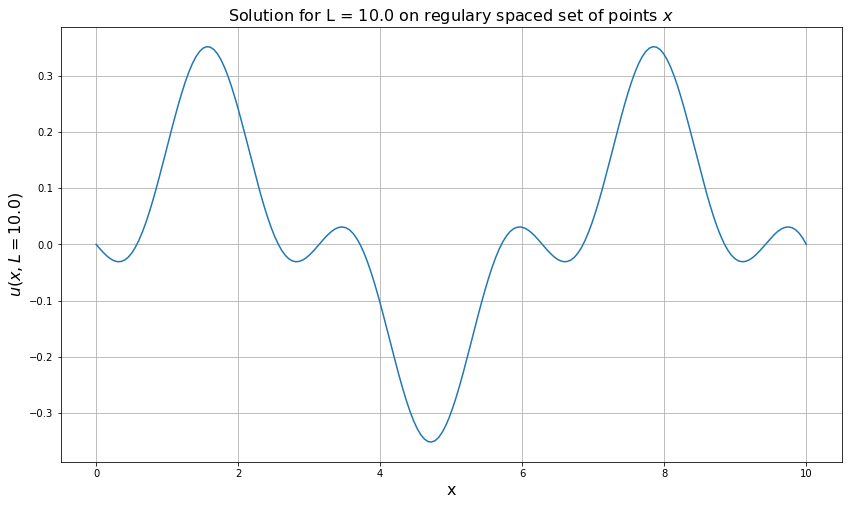

In [45]:
L = 10.
N = 200
x = numpy.linspace(0, L, N)
    

def u_true(x, L):
    return (1/8)*(numpy.sin(3*L) * numpy.sin(x) / numpy.sin(L) - numpy.sin(3*x))

u_true(1, 10)
fig = plt.figure(figsize=(14,8))
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, u_true(x, L))
axes.set_title(f"Solution for L = {L} on regulary spaced set of points $x$", fontsize = 16)
axes.set_xlabel("x", fontsize = 16)
axes.set_ylabel(f"$u(x, L = {L})$", fontsize = 16)
axes.grid()
plt.show()


**(b)** [8] Write a general shooting algorithm that combines the two scipy routines

* scipy.integrate.solve_ivp
* scipy.optimized.root_scalar

and returns the solution evaluated at an evenly spaced set of points $\mathbf{x}$.  

Some hints

* use `dense_output = True` in solve_ivp
* you can introduce a second def within shoot_bvp for use in root_scalar

For convenience (and testing), I've provided the interface introduced in class for a routine that can handle a range of boundary conditions and can control relative and absolute tolerance.

In [46]:
#  write a general shooting algorithm

from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

def shoot_bvp(f, x, u_a, u_b, i_a, i_b, rtol=1.e-5, atol=1.e-9):
    """
    Solve the two-point boundary value problem on the interval x\in [a,b], using a shooting method that combines 
        scipy.integrate.solve_ivp and scipy.optimize.root_scalar and allows a range of boundary conditions
        
        
    parameters:
    -----------
    f: calleable 
        vector value function for righthand side of the ODE with interface f(t,u). returns ndarray of length 2
    x: numpy array
        coordinates array for solution  on interval [a,b] with x[0] = a, x[-1] = b
    u_a:  numpy array (length 2)
        provide initial boundary conditions  [u, u' ] at x=a
    u_b:  numpy array (length 2)
        target boundary condition at x = b
    i_a: integer
        index of known boundary condition at x = a.  i.e.
        if dirichlet conditions : i_a = 0 and u(a) is known  
        if neumann conditions   : i_a = 1 and u'(a) is known
        the complementary index is adjusted to match the boundary condition at b
    i_b: integer
        index of known boundary condition at x = b. i.e.
        if dirichlet conditions : i_b = 0 and u(b) is known  
        if neumann conditions   : i_b = 1 and u'(b) is known
        the complementary index is ignored at b
    rtol:  float
        relative tolerance
    atol:  float
        absolute tolerance
        
    returns:
    --------
    u: solution u(x) for x (uses dense_output from solve_ivp to interpolate solution onto x)
    """
    
# YOUR CODE HERE
    def udiff(u_var):
        
        u_a[abs(i_a-1)]=u_var
        sol = solve_ivp(f, [x[0], x[-1]], u_a, dense_output=True, rtol=rtol, atol=atol)
        return (sol.y[i_b, -1] - u_b[i_b])
    
    root = root_scalar(udiff, x0=u_a[abs(i_a-1)], x1=u_a[abs(i_a-1)]+1, rtol=rtol, xtol=atol, method='secant')
    u_a[abs(i_a-1)] = root.root
    sol= solve_ivp(f, [x[0], x[-1]], u_a, dense_output=True, rtol=rtol, atol=atol)
    return sol.sol(x)[0]
    


**(c)** [4] rewrite the original problem 

$$
    u^{\prime\prime} + u = \sin(3x)
$$

as a system of first order ODE's

$$
    \frac{d\mathbf{v}}{dx} = \mathbf{f}(x,\mathbf{v})
$$  

and solve using the interface

`u_sol = shoot_bvp(f, x, u_a, u_b, i_a, i_b)`

* make a plot comparing your shooting solution with the true solution.

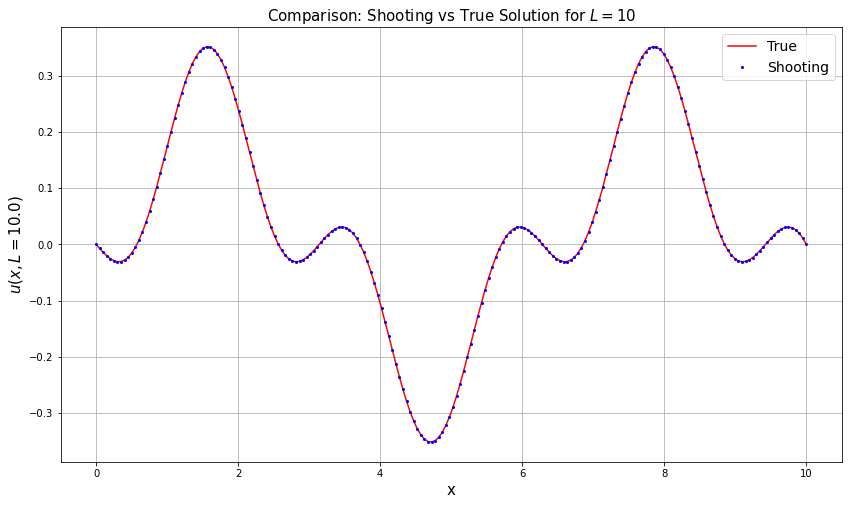

In [47]:
# YOUR CODE HERE
f = lambda x, u: numpy.array([u[1], numpy.sin(3*x) - u[0]])

u_a = [0,0]
u_b = [0,0]

i_a= 0
i_b =0

u_sol = shoot_bvp(f, x, u_a, u_b, i_a, i_b, rtol = 1.e-6)

fig = plt.figure(figsize=(14, 8))
axes = fig.add_subplot(1,1,1)
axes.plot(x, u_true(x, L), 'r', label = 'True')
axes.plot(x, u_sol, 'o', markersize = 2, color = 'b', label = 'Shooting')
axes.set_xlabel("x", fontsize = 15)
axes.set_ylabel(f"$u(x,L = {L})$", fontsize = 15)
axes.set_title("Comparison: Shooting vs True Solution for $L = 10$", fontsize = 15)
axes.legend(fontsize = 14)
axes.grid()
plt.show()

The following cell tests your shooting code against the true solution.  Adjust the relative and absolute tolerances in shoot_bvp, to make sure the following test passes with relative error $<10^{-6}$

In [48]:
#  test the solution against the true solution and pass if relative error < 1.e-6

rel_err = numpy.linalg.norm(u_sol - u_true(x,L))/numpy.linalg.norm(u_true(x,L))
print('relative error = {}'.format(rel_err))

assert(rel_err < 1.e-6)
print('success')

relative error = 3.6412985178731756e-07
success


**(d)** [8] Repeat the exercise but use the 2nd order finite difference methods introduced in class.  For convenience I have provided the routines for assembly of sparse 2nd derivative matrices and RHS from class.  

In [49]:
# routines from class  for generating 2nd order sparse second derivative operator and RHS vector

from fdcoeffV import fdcoeffV
from scipy.sparse import lil_matrix, identity, spdiags
from scipy.sparse.linalg import spsolve

def D2(x,bcs=['dirichlet', 'dirichlet']):
    """  
        Assemble a general sparse second-order finite-difference approximation to d/dx^2 on a possibly irregular mesh
        First and last rows are set by string bcs
        
        parameters:
        -----------
        x: numpy.array
            mesh coordinates
        bcs: list of strings for boundary conditions e.g [left_string, right_string] where
            the strings can be either 'dirichlet' or 'neumann'
    """
    N = len(x)
    A = lil_matrix((N,N))
    if bcs[0] == 'dirichlet':
        A[0,0] = 1.
    elif bcs[0] == 'neumann':
        A[0,0:3] = fdcoeffV(1,x[0],x[:3])
    else:
        raise ValueError('no known BC type for left boundary {}'.format(bcs[0]))
        
    if bcs[1] == 'dirichlet':
        A[-1,-1] = 1.
    elif bcs[1] == 'neumann':
        A[-1,-3:] = fdcoeffV(1,x[-1],x[-3:])
    else:
        raise ValueError('no known BC type for right boundary {}'.format(bcs[1]))
        
    for i in range(1,N-1):
        A[i, i-1:i+2] = fdcoeffV(2, x[i], x[i-1:i+2] )        
    return A.tocsr()

def RHS(x, f, bvalues):
    """ Set the rhs vector
    
        parameters
        ----------
        x: numpy.array
            mesh coordinates
        f: callable
            rhs function for interior points called on f(x[1:-2])
        bvalues:  numpy.array (len 2)
            values for boundary conditions (either dirichlet or neumann)        
    """
    
    N = len(x)
    rhs = numpy.empty(N)
    rhs[[0, N-1]] = bvalues
    rhs[1:-1] = f(x[1:-1])
    
    return rhs
    

Create a well-labeled convergence plot showing the relative error 

$$
    e_{rel} = \frac{|| u - u_{true} ||}{||u_{true}||}
$$

as a function of grid spacing $\Delta x$

This plot should calculate and show

* rate of convergence of error (i.e. find $p$ such that $e_{rel}\propto \Delta x^p$)
* an estimate of the  number of grid points $N$ required for the relative error to be $\leq 10^{-6}$
* the relative error at this smallest mesh spacing

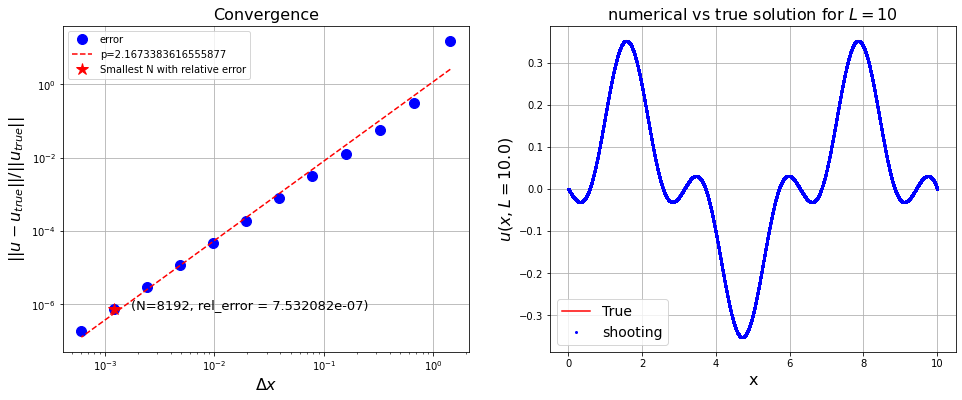

estimated number of N required for the relative error <= 10^-6:	 N =  8192
Relative error at this smallest mesh spacing:	 7.532082e-07


In [50]:
# Make a well labeled convergence plot that shows  convergence rate of relative error vs grid spacing

# YOUR CODE HERE
N = [ 2**n for n in range(3, 15) ]
rel_err = numpy.empty(len(N))
delta_x = numpy.empty(len(N))

i_flag = False
for i, n in enumerate(N):
    x = numpy.linspace(0, L, n)
    A = D2(x) + identity(len(x))
    f = RHS(x, lambda x: numpy.sin(3*x), [0., 0. ])
    u = spsolve(A, f)
    rel_err[i] = numpy.linalg.norm(u - u_true(x,L))/numpy.linalg.norm(u_true(x,L))
    delta_x[i] = x[1] - x[0]
    if (rel_err[i] <= 1e-6) and not i_flag:
        smallest_N_index = i
        i_flag = True
p = numpy.polyfit(numpy.log(delta_x), numpy.log(rel_err),1)
dx = numpy.logspace(numpy.log10(delta_x[0]), numpy.log10(delta_x[-1]), 100)
err = numpy.exp(p[1])*dx**p[0]

fig, axes = plt.subplots(1,2, figsize=(16,6))

axes[0].loglog(delta_x, rel_err, 'o', label='error', markersize=10, color ='b')
axes[0].loglog(dx,err,'r--',label="p={}".format(p[0]))
axes[0].loglog(delta_x[smallest_N_index], rel_err[smallest_N_index], 'r*', markersize = 12, label = 'Smallest N with relative error')
axes[0].annotate('(N='+str(N[smallest_N_index])+f', rel_error = {rel_err[smallest_N_index]:2e}'+')',
                (delta_x[smallest_N_index]+ 0.5e-3, rel_err[smallest_N_index]), fontsize=13)

axes[0].set_title("Convergence", fontsize = 16)
axes[0].set_xlabel("$\Delta x$", fontsize = 16)
axes[0].set_ylabel("$||u-u_{true}||/||u_{true}||$", fontsize = 16)
axes[0].legend(loc='best')
axes[0].grid()

axes[1].plot(x, u_true(x, L), 'r', label = 'True')
axes[1].plot(x, u, 'o', markersize = 2, color = 'b', label = 'shooting')
axes[1].set_xlabel("x", fontsize = 16)
axes[1].set_ylabel(f"$u(x,L = {L})$", fontsize = 16)
axes[1].set_title("numerical vs true solution for $L = 10$", fontsize = 16)
axes[1].legend(fontsize=14)
axes[1].grid()
plt.show()
                   
print("estimated number of N required for the relative error <= 10^-6:\t N = ", N[smallest_N_index])
print(f"Relative error at this smallest mesh spacing:\t{rel_err[smallest_N_index]: 2e}")

### Some themes and variations

This is meant to be a short problem set, but there are many other things to try if you are interested.

* Try this problem using Galerkin Finite Elements.  
* Try modifying the matrices to use higher order Finite difference schemes (i.e. 4th order schemes)
* Compare timing between Finite Difference and shooting schemes for the same order of accuracy


## Question 2 - Non-Linear Fun

try to solve the related  **non-linear** 2-point boundary value problem

$$
u^{\prime\prime}+\sin(u)=\sin(3x),\quad x\in[0,10],\quad u(0)=u(10)=0
$$

using  finite-difference plus Newton's method. For convenience, I've added the Newton Solver for sparse jacobians from the notes

In [51]:
# a Newton Solver for sparse matrices
def newton(F,J,x0,tol=1.e-6,MAX_ITS=100,verbose=True):
    """ Solve F(x) = 0 using Newton's method until ||F(x)|| < tol or reaches Max iterations
    
    Params:
    -------
        F: calleable: 
            Function returning residual F(x)
        J: calleable
            Function returning Jacobian J(x)
        tol: float
            stopping criteria for ||F|| < tol
        MAX_ITS: integer
            maximum number of iterations
        verbose: bool
            if true spits out norm of the residual at each iteration
            
    Returns:
    --------
        x: numpy.array
            solution
        k: int
            number of iterations
    
    Raises:
    -----------
        ValueError if number of its exceeds MAX_ITS
        
    """
    x = [x0] 
    res_k = []
    for k in range(MAX_ITS+1):
        x_k = x[k]
        res = numpy.linalg.norm(F(x_k))
        res_k.append(res)
        if verbose:
            print('k = {}, ||F|| = {}'.format(k,res))
        if res < tol: 
            return x, k, res_k
        delta = spsolve(J(x_k),-F(x_k))
        x.append(delta + x_k)
        
    raise ValueError('Maximum number of iterations exceeded {}'.format(MAX_ITS))

**(a)** [4 pt]  Solve the problem for an initial guess
$u_0=0$. For this problem you will need to

* create a function to return the residual $\mathbf{F}(\mathbf{u})$
* create a function to return the Jacobian $J(\mathbf{u})$
* use `verbose=True` to see the convergence behavior of Newton
* produce a plot showing the solution and labeled with the number of newton iterations and final residual norm $||\mathbf{F}(\mathbf{u})||$

**Note:**  To choose a reasonable number of grid points, use your results from Question 1 and choose a mesh size such that the linear problem returns a relative error $< 10^{-3}$

k = 0, ||F|| = 11.29852327626356
k = 1, ||F|| = 0.04530162620888393
k = 2, ||F|| = 0.0012877576334417266
k = 3, ||F|| = 1.7447245735008314e-06
k = 4, ||F|| = 3.3953151067875207e-12


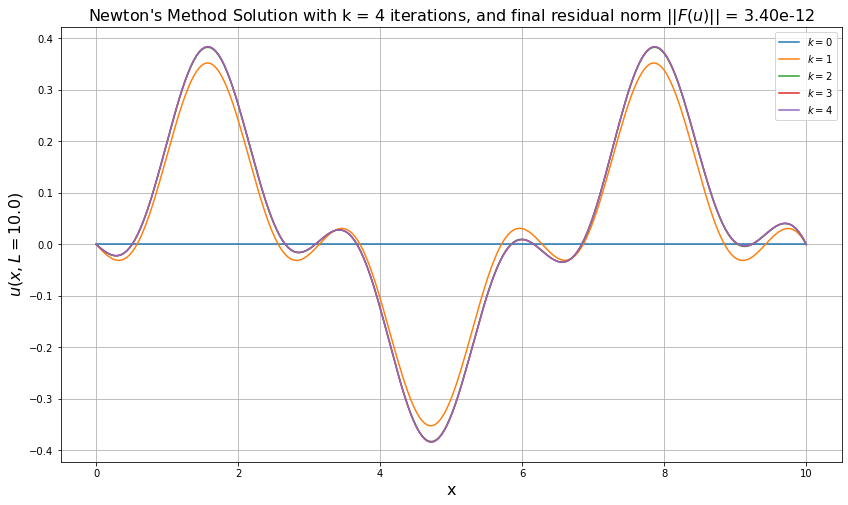

In [52]:
# YOUR CODE HERE
N = 2**8
x = numpy.linspace(0., L, N)
A = D2(x)

def F(u):
    f = A.dot(u)+ numpy.sin(u) - numpy.sin(3*x)
    f[[0,-1]] = 0
    return f

def J(u):
    n = len(u)
    return A + spdiags(numpy.cos(u), 0, n, n)

u0 = list(numpy.linspace(0., 0., N))
sol, its, res = newton(F,J,u0)

fig = plt.figure(figsize=(14, 8))
axes = fig.add_subplot(1,1,1)
for k in range(its+1):
    axes.plot(x, sol[k], label="$k={}$".format(k))
axes.grid()
axes.legend(loc='best')
axes.set_xlabel("x", fontsize = 16)
axes.set_ylabel(f"$u(x,L = {L})$", fontsize = 16)
axes.set_title(f"Newton's Method Solution with k = {k} iterations, and final residual norm $||F(u)||$ = {res[-1]:.2e}", fontsize = 16)
plt.show()


**(b)**  Is your solution unique?  Try starting newton from different
  periodic initial conditions 
  
  $$
      u_0(x) = \sin\left[\frac{n\pi x}{L}\right]
  $$ 
  
  for $n\in[0,6]$ that all satisfy the homogeneous boundary conditions. 
  
  Make two plots. 
  
  1. The first shows solutions for different values of $n$
  1. The second plots the residual $\mathbf{F}(\mathbf{u})$ to show that at least the discrete ODE is satisfied
  
 Welcome to the wonderful world of non-linear equations. Can you find any other solutions?

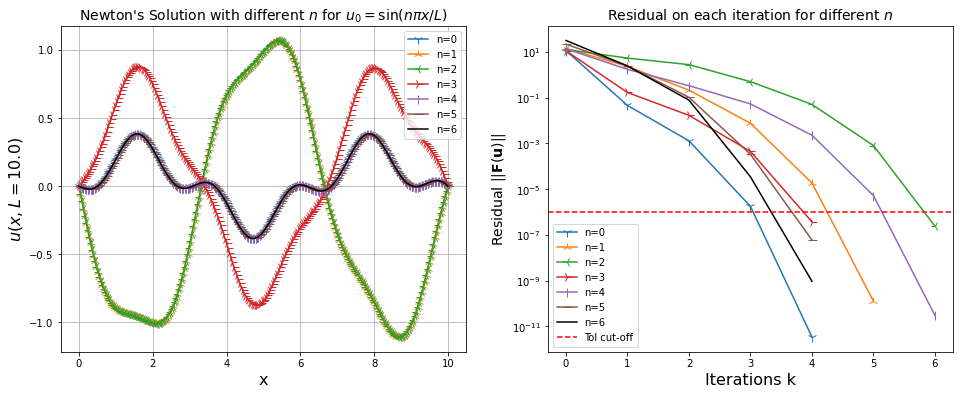

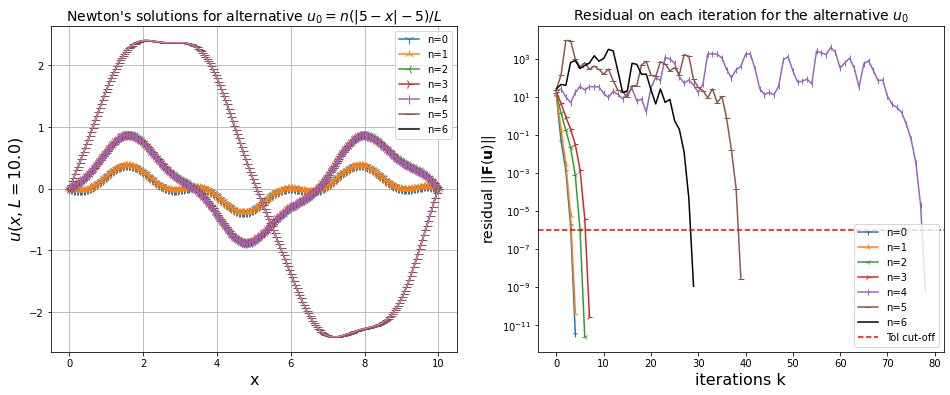

In [53]:
# YOUR CODE HERE
n_range = range(0, 7)

res_list = []
fig, axes = plt.subplots(1,2, figsize=(16,6))

L_ = ["-1", "-2", "-3", "-4", "-|","-_","-0"]

for n in n_range:
    u0 = numpy.sin(n*numpy.pi*x/L)
    sol, its, res = newton(F,J,u0, verbose = False)
    res_list.append(res)
    axes[0].plot(x, sol[-1], L_[n], label='n='+str(n), markersize=9)
    
axes[0].set_xlabel("x", fontsize = 16)
axes[0].set_ylabel(f"$u(x,L = {L})$", fontsize = 16)
axes[0].set_title("Newton's Solution with different $n$ for $u_0=\sin(n\pi x/L)$", fontsize = 14)
axes[0].legend()
axes[0].grid()

for n in n_range:
    axes[1].semilogy(res_list[n],L_[n], label ='n='+str(n),markersize=9)
    
axes[1].axhline(y=1e-6, color='r', linestyle='--', label =  'Tol cut-off')
axes[1].set_xlabel('Iterations k', fontsize = 16)
axes[1].set_ylabel('Residual $||\mathbf{F}(\mathbf{u})||$', fontsize = 14)
axes[1].set_title('Residual on each iteration for different $n$', fontsize=14)
axes[1].legend()
axes[1].grid
plt.show

fig, axes = plt.subplots(1, 2, figsize=(16,6))
res_list = []
for n in n_range:
    u0 = n*numpy.abs(5-x)/L - n*5/L
    sol, its, res = newton(F,J,u0, verbose=False)
    res_list.append(res)
    axes[0].plot(x, sol[-1], L_[n], label='n='+str(n), markersize=9)
axes[0].plot(x, sol[-1])
axes[0].set_xlabel("x", fontsize = 16)
axes[0].set_ylabel(f"$u(x, L = {L})$", fontsize = 16)
axes[0].set_title("Newton's solutions for alternative $u_0=n(|5-x|-5)/L$", fontsize = 14)
axes[0].legend()
axes[0].grid()

for n in n_range:
    axes[1].semilogy(res_list[n], L_[n], label='n='+str(n))
    
axes[1].axhline(y=1e-6, color='r', linestyle='--', label = 'Tol cut-off')
axes[1].set_xlabel('iterations k', fontsize = 16)
axes[1].set_ylabel('residual $||\mathbf{F}(\mathbf{u})||$', fontsize = 14)
axes[1].set_title("Residual on each iteration for the alternative $u_0$", fontsize = 14)
axes[1].legend()
plt.show()

### Extra Fun

Use your shooting routines to systematically search for non-linear solutions to this BVP problem by varying the initial guess for the initial slope $u'(0)$. How many solutions can you find?